In [1]:
import numpy as np
import os
import pandas as pd
from jinja2 import Template
import subprocess
#from matplotlib import pyplot as plt
#from multiprocessing import Pool
import multiprocessing
import sqlite3
import glob
import openpyxl
import itertools
from scipy.stats import norm
import matplotlib.pyplot as plt

from functools import partial

In [2]:
np.set_printoptions(precision=8, suppress=True)
%matplotlib inline

In [3]:
#from matplotlib import pyplot as plt
#import seaborn as sns
#sns.set_style('darkgrid')
#%matplotlib inline

In [4]:
# %load pso.py
from functools import partial
import numpy as np
from diversipy import hycusampling

def _obj_wrapper(func, args, kwargs, x):
    return func(x, *args, **kwargs)

def _is_feasible_wrapper(func, x):
    return np.all(func(x)>=0)

def _cons_none_wrapper(x):
    return np.array([0])

def _cons_ieqcons_wrapper(ieqcons, args, kwargs, x):
    return np.array([y(x, *args, **kwargs) for y in ieqcons])

def _cons_f_ieqcons_wrapper(f_ieqcons, args, kwargs, x):
    return np.array(f_ieqcons(x, *args, **kwargs))
    
def pso(func, lb, ub, ieqcons=[], f_ieqcons=None, args=(), kwargs={}, 
        swarmsize=100, omega=0.5, phip=0.9, phig=0.1, maxiter=100, 
        minstep=1e-8, minfunc=1e-8, debug=True, processes=1,
        particle_output=False):
    """
    Perform a particle swarm optimization (PSO)
   
    Parameters
    ==========
    func : function
        The function to be minimized
    lb : array
        The lower bounds of the design variable(s)
    ub : array
        The upper bounds of the design variable(s)
   
    Optional
    ========
    ieqcons : list
        A list of functions of length n such that ieqcons[j](x,*args) >= 0.0 in 
        a successfully optimized problem (Default: [])
    f_ieqcons : function
        Returns a 1-D array in which each element must be greater or equal 
        to 0.0 in a successfully optimized problem. If f_ieqcons is specified, 
        ieqcons is ignored (Default: None)
    args : tuple
        Additional arguments passed to objective and constraint functions
        (Default: empty tuple)
    kwargs : dict
        Additional keyword arguments passed to objective and constraint 
        functions (Default: empty dict)
    swarmsize : int
        The number of particles in the swarm (Default: 100)
    omega : scalar
        Particle velocity scaling factor (Default: 0.5)
    phip : scalar
        Scaling factor to search away from the particle's best known position
        (Default: 0.5)
    phig : scalar
        Scaling factor to search away from the swarm's best known position
        (Default: 0.5)
    maxiter : int
        The maximum number of iterations for the swarm to search (Default: 100)
    minstep : scalar
        The minimum stepsize of swarm's best position before the search
        terminates (Default: 1e-8)
    minfunc : scalar
        The minimum change of swarm's best objective value before the search
        terminates (Default: 1e-8)
    debug : boolean
        If True, progress statements will be displayed every iteration
        (Default: False)
    processes : int
        The number of processes to use to evaluate objective function and 
        constraints (default: 1)
    particle_output : boolean
        Whether to include the best per-particle position and the objective
        values at those.
   
    Returns
    =======
    g : array
        The swarm's best known position (optimal design)
    f : scalar
        The objective value at ``g``
    p : array
        The best known position per particle
    pf: arrray
        The objective values at each position in p
   
    """
   
    assert len(lb)==len(ub), 'Lower- and upper-bounds must be the same length'
    assert hasattr(func, '__call__'), 'Invalid function handle'
    lb = np.array(lb)
    ub = np.array(ub)
    assert np.all(ub>lb), 'All upper-bound values must be greater than lower-bound values'
   
    vhigh = np.abs(ub - lb)
    vlow = -vhigh

    # Initialize objective function
    obj = partial(_obj_wrapper, func, args, kwargs)
    
    # Check for constraint function(s) #########################################
    if f_ieqcons is None:
        if not len(ieqcons):
            if debug:
                print('No constraints given.')
            cons = _cons_none_wrapper
        else:
            if debug:
                print('Converting ieqcons to a single constraint function')
            cons = partial(_cons_ieqcons_wrapper, ieqcons, args, kwargs)
    else:
        if debug:
            print('Single constraint function given in f_ieqcons')
        cons = partial(_cons_f_ieqcons_wrapper, f_ieqcons, args, kwargs)
    is_feasible = partial(_is_feasible_wrapper, cons)

    # Initialize the multiprocessing module if necessary
    if processes > 1:
        import multiprocessing
        mp_pool = multiprocessing.Pool(processes)
        
    # Initialize the particle swarm ############################################
    S = swarmsize
    D = len(lb)  # the number of dimensions each particle has
    # x = np.random.rand(S, D)  # particle positions
    x = hycusampling.random_k_means(S, D)  # assigns points to voronoi centroids of the D-dimensional unit hypercube
    v = np.zeros_like(x)  # particle velocities
    p = np.zeros_like(x)  # best particle positions
    fx = np.zeros(S)  # current particle function values
    fs = np.zeros(S, dtype=bool)  # feasibility of each particle
    fp = np.ones(S)*np.inf  # best particle function values
    g = []  # best swarm position
    fg = np.inf  # best swarm position starting value
    v_history = []
    x_history = []
    fx_history = []
    g_history = []
    fg_history = []
    
    # Initialize the particle's position
    x = lb + x*(ub - lb)

    # Calculate objective and constraints for each particle
    if processes > 1:
        fx = np.array(mp_pool.map(obj, x))
        fs = np.array(mp_pool.map(is_feasible, x))
    else:
        for i in range(S):
            fx[i] = obj(x[i, :])
            fs[i] = is_feasible(x[i, :])
            
    fx_history.append(fx.copy())
    x_history.append(x.copy())
       
    # Store particle's best position (if constraints are satisfied)
    i_update = np.logical_and((fx < fp), fs)
    p[i_update, :] = x[i_update, :].copy()
    fp[i_update] = fx[i_update]

    # Update swarm's best position
    i_min = np.argmin(fp)
    if fp[i_min] < fg:
        fg = fp[i_min]
        g = p[i_min, :].copy()
    else:
        # At the start, there may not be any feasible starting point, so just
        # give it a temporary "best" point since it's likely to change
        g = x[0, :].copy()
    
    g_history.append(g.copy())
    fg_history.append(fg.copy())
    
    # Initialize the particle's velocity
    v = vlow + np.random.rand(S, D)*(vhigh - vlow)
       
    # Iterate until termination criterion met ##################################
    it = 1
    while it <= maxiter:
        rp = np.random.uniform(size=(S, D))
        rg = np.random.uniform(size=(S, D))

        # Update the particles velocities
        v = omega*v + phip*rp*(p - x) + phig*rg*(g - x)
        v_history.append(v)
        # Update the particles' positions
        x = x + v
        # Correct for bound violations
        maskl = x < lb
        masku = x > ub
        x = x*(~np.logical_or(maskl, masku)) + lb*maskl + ub*masku

        # Update objectives and constraints
        if processes > 1:
            fx = np.array(mp_pool.map(obj, x))
            fs = np.array(mp_pool.map(is_feasible, x))
        else:
            for i in range(S):
                fx[i] = obj(x[i, :])
                fs[i] = is_feasible(x[i, :])
        fx_history.append(fx.copy())
        x_history.append(x.copy())

        # Store particle's best position (if constraints are satisfied)
        i_update = np.logical_and((fx < fp), fs)
        p[i_update, :] = x[i_update, :].copy()
        fp[i_update] = fx[i_update]
        
        # Compare swarm's best position with global best position
        i_min = np.argmin(fp)
        if fp[i_min] < fg:
            if debug:
                print('New best for swarm at iteration {:}: {:} {:}'\
                    .format(it, p[i_min, :], fp[i_min]))

            p_min = p[i_min, :].copy()
            stepsize = np.sqrt(np.sum((g - p_min)**2))

            if np.abs(fg - fp[i_min]) <= minfunc:
                print('Stopping search: Swarm best objective change less than {:}'\
                    .format(minfunc))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            elif stepsize <= minstep:
                print('Stopping search: Swarm best position change less than {:}'\
                    .format(minstep))
                if particle_output:
                    return p_min, fp[i_min], p, fp
                else:
                    return p_min, fp[i_min]
            else:
                g = p_min.copy()
                fg = fp[i_min]
        g_history.append(g.copy())        
        fg_history.append(fg.copy())

        if debug:
            #print('Best after iteration {:}: {:} {:}'.format(it, g, fg))
            print('Best after iteration {:}: {:}'.format(it, fg))
        it += 1

    print('Stopping search: maximum iterations reached --> {:}'.format(maxiter))
    
    if processes > 1:
        mp_pool.close()
    
    if not is_feasible(g):
        print("However, the optimization couldn't find a feasible design. Sorry")
    if particle_output:
       # return g, fg, p, fp
        return g, fg, p, fp, x_history, fx_history, v_history, g_history, fg_history
    else:
        return g, fg


In [5]:
def make_param_dict(params, species, stand_id):
    ''' Single species
        FIXDG (diameter growth multiplier by species and diameter class)
        MORTMULT (background mortality rate multiplier by species and diameter class)
        SDIMAX (density-driven mortality parameter set for each species)
    '''
    param_dict = {}
    #stand input
    param_dict['stand_id'] = stand_id
    
    #input and output databases
    param_dict['FVSIn'] = '../data/FVSIn.db'
    param_dict['FVSOut'] = '../keyfiles/{}.db'.format(stand_id)

    param_dict['species']  = int(species)
    
    #growth factors
    #size classes: 3-5, 5-10, 10-15, 15-20, >20
    #param_dict['species'] = int(params[0])
    param_dict['FIXDGm_0'] = round(params[0],8)
    param_dict['FIXDGm_1'] = round(params[1],8)
    param_dict['FIXDGm_2'] = round(params[2],8)
    param_dict['FIXDGm_3'] = round(params[3],8)
    param_dict['FIXDGm_4'] = round(params[4],8)
    #background mortality factors
    #param_dict['MORTm_sp'] = int(params[0])
    param_dict['MORTm_0'] = round(params[5],8)
    param_dict['MORTm_1'] = round(params[6],8)
    param_dict['MORTm_2'] = round(params[7],8)
    param_dict['MORTm_3'] = round(params[8],8)
    param_dict['MORTm_4'] = round(params[9],8)

    #density driven mortality factors
    param_dict['SDI_MAX'] = int(params[10])
    param_dict['SDI_LB'] = 55
    param_dict['SDI_UB'] = 85
        
    return param_dict

def make_keyfile(template, param_dict):
    filename = '../keyfiles/{}.key'.format(param_dict['stand_id'])
    keyfile_path = os.path.abspath(filename)
    with open(keyfile_path,'w') as keyfile:
        keyfile.write(template.render(**param_dict))

    return keyfile_path


def get_run_data(stand_id):
    CONN_STR = sqlite3.connect('../keyfiles/{}.db'.format(stand_id))
    try:
        run_data = pd.read_sql_query("SELECT * from fvs_summary", CONN_STR)
    except Exception as e:
        print(stand_id)
        raise()
    #run_data = pd.read_sql_query("SELECT * from fvs_summary", CONN_STR).set_index('standid')
    #run_data = pd.read_sql_query("SELECT * from fvs_compute", CONN_STR).set_index('standid')
    
    return run_data


def get_groundtruth(stand_id):
    STAND_DATA = '../data/groundtruth.xlsx'
    df = pd.read_excel(STAND_DATA).set_index('stand_id')

    return df.loc[stand_id]

def get_residuals(stand_id):

    METRICS = ['Acc','Mort']
    #ACC = ['comp_acc']
    #MORT = ['comp_mort']
    pred = get_run_data(stand_id)[METRICS].head(1)
    obs = get_groundtruth(stand_id)[METRICS]

    residuals = pred - obs
    
    return residuals

def get_keyfile_template(path_to_template):
    with open(path_to_template, 'r') as base_keyfile:
        template = Template(base_keyfile.read())
    return template


def run_fvs(params, species, stand_id):
    param_dict = make_param_dict(params, species, stand_id)
    KEYFILE_TEMPLATE = '../models/Base_Rx.key'
    template = get_keyfile_template(KEYFILE_TEMPLATE)
    keyfile = make_keyfile(template, param_dict)

    proc = subprocess.call(['/usr/local/bin/FVSnc',
                           '--keywordfile={}'.format(keyfile)],
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)

    # cleanup output files
    try:
        os.remove('../keyfiles/{}.out'.format(stand_id))
        os.remove('../keyfiles/{}.key'.format(stand_id))
        os.remove('../keyfiles/{}_RegenRpt.txt'.format(stand_id))
    except OSError: 
        pass

    return proc


def run_score_batch(params, all_stands, species, sample_size, num_cores, target):
    """
    Objective function to be optimized by PSO.

    Parameters
    ----------
    params : array
      parameters being tested in this step of the PSO
    stand_ids : array
      stands that will be simulated in this step of the PSO
    num_cores : int
      number of cores that will be used for parallel processing
    target : str
      one of 'growth', 'mortality', or 'both'

    Returns
    -------
    obj_fun : scalar
      score of objective function on this batch of simulations
    """
    stand_ids = np.random.choice(all_stands, sample_size)

    args =[(params, species, id) for id in stand_ids]
    with multiprocessing.Pool(num_cores) as p:
        procs = p.starmap(run_fvs, args)
        resids = p.map(get_residuals, stand_ids)
    
    map_to_run = partial(run_fvs, params, species)
    with multiprocessing.Pool(num_cores) as p:
        procs = p.map(map_to_run, stand_ids)
        resids = p.map(get_residuals, stand_ids)
    
    resid = pd.concat(resids, axis=0, ignore_index=True)

    # sse = ((residuals)**2)
    # mae = residuals.abs()
    # bias = residuals

#     growth_sse = (resid['Acc']**2).sum()
#     growth_mae = resid['Acc'].abs().mean()
#     growth_bias = resid['Acc'].mean()
    
    prior = np.array([1,1,1,1,1,1,1,1,1,1,650])
    prior_diff = params - prior
    mult_logprob = norm(loc=0, scale=.1).logpdf(prior_diff[:-1]).sum()
    sdi_logprob = norm(loc=0, scale=25).logpdf(prior_diff[-1])
    
    growth_logprob = norm(loc=0, scale=358).logpdf(resid['Acc']).sum()
        
#     mort_sse = (resid['Mort']**2).sum()
#     mort_mae = resid['Mort'].abs().mean()
#     mort_bias = resid['Mort'].mean()
                                               
    mort_logprob = norm(loc=0, scale=36).logpdf(resid['Mort']).sum()
    
    prior_logprob = mult_logprob + sdi_logprob

    
    if target == 'growth':
        #obj_fun = growth_sse
        obj_fun = -(prior_logprob + growth_logprob)
    elif target == 'mortality':
        #obj_fun = mort_sse
        obj_fun = -(prior_logprob + mort_logprob)
    else: 
        #obj_fun = growth_sse + mort_sse
        obj_fun = -(prior_logprob + growth_logprob + mort_logprob)
        #obj_fun = -(growth_logprob + mort_logprob)
    return obj_fun


In [6]:
LB = [0.5,   # 'FIXDGm_0'
      0.5,   # 'FIXDGm_1'
      0.5,   # 'FIXDGm_2'
      0.5,   # 'FIXDGm_3'
      0.5,   # 'FIXDGm_4'
      0.5,   # 'MORTm_0'
      0.5,   # 'MORTm_1'
      0.5,   # 'MORTm_2'
      0.5,   # 'MORTm_3'
      0.5,   # 'MORTm_4'
      300,   # 'SDI_MAX'
]             

UB = [1.5,   # 'FIXDGm_0'
      1.5,   # 'FIXDGm_1'
      1.5,   # 'FIXDGm_2'
      1.5,   # 'FIXDGm_3'
      1.5,   # 'FIXDGm_4'
      1.5,   # 'MORTm_0'
      1.5,   # 'MORTm_1'
      1.5,   # 'MORTm_2'
      1.5,   # 'MORTm_3'
      1.5,   # 'MORTm_4'
      1000,   # 'SDI_MAX'
]  

stand_data = pd.read_excel('../data/groundtruth.xlsx')
all_stands = np.unique(stand_data.stand_id)

In [7]:
#     g, fg, p, fp, x_history, fx_history, v_history, g_history, fg_history = pso(run_score_batch, lb=LB, ub=UB,
#                            swarmsize=48, maxiter=20, processes=1,
#                            kwargs={'num_cores': 48, 
#                                    'all_stands': all_stands,
#                                    'sample_size': 96,
#                                    'target': 'both',
#                                    'species': 202
#                                    }

In [9]:
%%time

combine = []
for i in range(10):
    g, fg = pso(run_score_batch, lb=LB, ub=UB,
                           swarmsize=48, maxiter=20, processes=1,
                           kwargs={'num_cores': 48, 
                                   'all_stands': all_stands,
                                   'sample_size': 96,
                                   'target': 'both',
                                   'species': 202
                                   })

    run_results = pd.DataFrame(g, index=['FIXDGm_0', 'FIXDGm_1', 'FIXDGm_2', 'FIXDGm_3', 'FIXDGm_4',
                                    'MORTm_0', 'MORTm_1', 'MORTm_2', 'MORTm_3', 'MORTm_4', 'SDI_MAX'])
    run_results.columns = [round(fg, 1)]
    
    combine.append(run_results)

combined = pd.concat(combine, axis = 1)

No constraints given.
Best after iteration 1: 1368.4965757263146
Best after iteration 2: 1368.4965757263146
Best after iteration 3: 1368.4965757263146
New best for swarm at iteration 4: [  0.63009067   0.64037849   1.04112262   0.97733852   0.63203083
   0.69024571   0.99853699   0.64072582   0.59870274   0.5
 936.63843181] 1318.5787491530677
Best after iteration 4: 1318.5787491530677
New best for swarm at iteration 5: [  0.97545592   0.6810717    1.12256441   0.91587605   0.84332932
   1.23549886   0.75262149   1.10026256   0.92820821   0.7303905
 597.69279058] 1178.14104279131
Best after iteration 5: 1178.14104279131
Best after iteration 6: 1178.14104279131
Best after iteration 7: 1178.14104279131
Best after iteration 8: 1178.14104279131
Best after iteration 9: 1178.14104279131
Best after iteration 10: 1178.14104279131
Best after iteration 11: 1178.14104279131
Best after iteration 12: 1178.14104279131
Best after iteration 13: 1178.14104279131
Best after iteration 14: 1178.14104279131

Best after iteration 6: 1302.7453554958292
New best for swarm at iteration 7: [  0.89471374   0.56930845   0.90322616   0.51491823   0.71513356
   1.17161241   1.38051254   1.33588487   1.26586763   1.10608268
 707.81075111] 1275.0604365461422
Best after iteration 7: 1275.0604365461422
Best after iteration 8: 1275.0604365461422
Best after iteration 9: 1275.0604365461422
Best after iteration 10: 1275.0604365461422
Best after iteration 11: 1275.0604365461422
New best for swarm at iteration 12: [  1.1799905    1.19501919   0.69961885   1.14437005   0.80714363
   0.86529313   1.24044306   1.18321538   1.24520824   1.06942932
 638.09533062] 1273.8895501477423
Best after iteration 12: 1273.8895501477423
New best for swarm at iteration 13: [  0.71336532   0.58673461   0.80699865   1.33528438   0.52478964
   0.65491661   1.07848573   1.20150914   0.89200572   1.03890745
 361.4959897 ] 1266.5685052294275
Best after iteration 13: 1266.5685052294275
Best after iteration 14: 1266.5685052294275
Bes

In [35]:
combined.T.sort_index()

,FIXDGm_0,FIXDGm_1,FIXDGm_2,FIXDGm_3,FIXDGm_4,MORTm_0,MORTm_1,MORTm_2,MORTm_3,MORTm_4,SDI_MAX
mult,,,,,,,,,,,
1151.6,0.649050,0.695766,0.892069,0.924684,0.900751,1.011054,1.167582,1.178590,1.050361,1.006640,580.449140
1175.3,0.539753,1.248062,1.048514,0.872242,1.031146,1.225914,1.003077,1.096549,1.130696,1.113349,644.411935
1175.4,0.982534,1.272824,1.256374,0.898475,0.819428,0.918688,0.922446,0.864724,1.217689,1.169335,647.522908
1178.1,0.975456,0.681072,1.122564,0.915876,0.843329,1.235499,0.752621,1.100263,0.928208,0.730390,597.692791
1186.3,1.171961,1.065488,1.192227,1.260282,0.765391,0.802900,0.974715,0.825551,0.891001,1.069205,798.602176
1214.6,0.839497,0.880161,1.149288,1.072862,0.706348,0.968347,0.925058,0.821307,1.106732,1.402311,610.369317
1220.9,0.710301,1.035414,1.169390,0.512617,0.859746,0.509788,0.862822,0.796693,1.324497,0.762023,661.411036
1239.1,1.223339,0.685003,1.411639,1.018125,0.781872,1.424929,1.320424,0.916072,1.011745,1.073209,603.524883
1246.4,1.176214,0.832719,0.934867,1.020313,1.044186,0.666360,1.390145,1.002098,0.782002,0.928679,508.805220


In [11]:
run_results = pd.DataFrame(g, 
                           index=['FIXDGm_0', 'FIXDGm_1', 'FIXDGm_2', 'FIXDGm_3', 'FIXDGm_4',
                                    'MORTm_0', 'MORTm_1', 'MORTm_2', 'MORTm_3', 'MORTm_4', 'SDI_MAX']
                        
                           )
print(run_results)


                   0
FIXDGm_0    0.982534
FIXDGm_1    1.272824
FIXDGm_2    1.256374
FIXDGm_3    0.898475
FIXDGm_4    0.819428
MORTm_0     0.918688
MORTm_1     0.922446
MORTm_2     0.864724
MORTm_3     1.217689
MORTm_4     1.169335
SDI_MAX   647.522908


In [26]:
# run_results.columns = [round(fg, 0)]
# combine = combine.join(run_results)
# combine

combo

mult,1178.1,1175.3,1252.1,1214.6,1220.9,1246.4,1151.6,1239.1,1186.3,1175.4
FIXDGm_0,0.975456,0.539753,0.938515,0.839497,0.710301,1.176214,0.649050,1.223339,1.171961,0.982534
FIXDGm_1,0.681072,1.248062,1.032179,0.880161,1.035414,0.832719,0.695766,0.685003,1.065488,1.272824
FIXDGm_2,1.122564,1.048514,0.997056,1.149288,1.169390,0.934867,0.892069,1.411639,1.192227,1.256374
FIXDGm_3,0.915876,0.872242,0.930167,1.072862,0.512617,1.020313,0.924684,1.018125,1.260282,0.898475
FIXDGm_4,0.843329,1.031146,0.586009,0.706348,0.859746,1.044186,0.900751,0.781872,0.765391,0.819428
MORTm_0,1.235499,1.225914,1.141533,0.968347,0.509788,0.666360,1.011054,1.424929,0.802900,0.918688
MORTm_1,0.752621,1.003077,1.500000,0.925058,0.862822,1.390145,1.167582,1.320424,0.974715,0.922446
MORTm_2,1.100263,1.096549,0.658962,0.821307,0.796693,1.002098,1.178590,0.916072,0.825551,0.864724
MORTm_3,0.928208,1.130696,0.959618,1.106732,1.324497,0.782002,1.050361,1.011745,0.891001,1.217689
MORTm_4,0.730390,1.113349,1.263495,1.402311,0.762023,0.928679,1.006640,1.073209,1.069205,1.169335


In [44]:
# combo = combined[:-1]
# combo = combo.reindex(sorted(combo.columns), axis=1)
# ax = combo.plot(figsize=(14, 6))
# ax.set_ylabel('Muliplier Value', fontsize=12)
# #ax.set_xlabel('Multiplier', fontsize=12)
# plt.axhline(y = 1, color = 'black', linestyle = 'dashed')  
# plt.show()

In [37]:
# x_array = np.array(x_history)
# x_array.shape

In [38]:
# #x_array[0,:,-1]

# names=['iteration_num', 'particle_num', 'z']

# index = pd.MultiIndex.from_product([range(s) for s in x_array.shape], names=names)
# x_df = pd.DataFrame(x_array.flatten(), index=index)
# x_df = x_df.unstack(level='z').swaplevel().sort_index()
# x_df.columns = ['FIXDGm_0', 'FIXDGm_1', 'FIXDGm_2', 'FIXDGm_3', 'FIXDGm_4',
#         'MORTm_0', 'MORTm_1', 'MORTm_2', 'MORTm_3', 'MORTm_4', 'SDI_MAX']
# x_df = x_df.reset_index()

In [39]:
# fx_array = np.array(fx_history)
# #fx_array

In [40]:
# names=['iteration_num', 'particle_num']

# index = pd.MultiIndex.from_product([range(s) for s in fx_array.shape], names=names)
# fx_df = pd.DataFrame(fx_array.flatten(), index=index).reset_index()
# fx_df.columns = ['iteration_num', 'particle_num', 'local_val']

In [41]:
# df =x_df.merge(fx_df, on=['iteration_num', 'particle_num'])

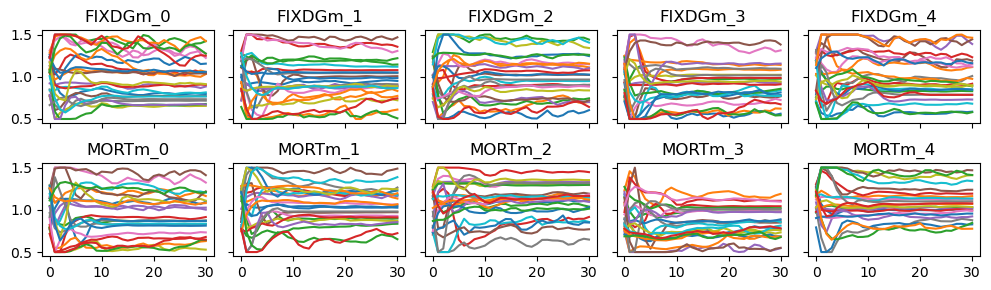

In [193]:
colnames =['FIXDGm_0', 'FIXDGm_1', 'FIXDGm_2', 'FIXDGm_3', 'FIXDGm_4',
        'MORTm_0', 'MORTm_1', 'MORTm_2', 'MORTm_3', 'MORTm_4', 'SDI_MAX']
swarmsize = 24
fig, axs = plt.subplots(nrows=2,ncols=5,figsize=(10,3), sharex=True, sharey=True)
for i in range(swarmsize):
    for j in range(10):
        axs.ravel()[j].plot(df.loc[df.particle_num == i, colnames[j]].values)
        axs.ravel()[j].set_title(colnames[j])
plt.tight_layout()
plt.show()

In [78]:
# # fig,axes = plt.subplots(nrows=5,ncols=2)
# plots = zip(mult1_xarray, fx_array)
# def loop_plot(plots):
#     figs={}
#     axs={}
#     for idx,plot in enumerate(plots):
#         figs[idx]=plt.figure()
#         axs[idx]=figs[idx].add_subplot(111)
#         axs[idx].scatter(plot[0],plot[1])
#     return figs, axs 
# figs, axs = loop_plot(plots)


In [92]:
pg

array([674.38275504, 715.1888757 , 620.22892419, 774.07550561,
       675.03189964, 851.91426586, 615.51380435, 849.03668466,
       727.11217304, 934.0885613 , 640.45344529, 870.58405473,
       647.12457947, 737.80564867, 634.14574497])

In [76]:
v_array = np.array(v_history)

In [77]:
v_array[0,:,-1]

array([  91.08892264,   84.45978076,  -28.73477936,   37.64044535,
        179.4054936 , -195.55273098,  124.9854865 ,  290.3332945 ,
       -152.21446983,  118.74921169, -165.22072707,   11.35696278,
       -195.23017427,   78.43586321, -140.11480019])

In [190]:
files = glob.glob('../keyfiles/*')
for f in files:
    os.remove(f)

In [ ]:
# xs = []
# fxs = []
# for site in SITES:
#     empty_database()
#     x, f_x = pso(partial(run_fvs, site_index=site, run_type='global'),
#                  LB, UB,  # bounds
#                  swarmsize=64,
#                  maxiter=25,
# #                  debug=True,
#                  processes=32,
#                  minfunc=0) # don't stop early
#     xs.append(x)
#     fxs.append(f_x)
#     pso_results.loc[site, 'sdi_max'] = np.round(x[0],0).astype(int)
#     pso_results.loc[site, 'df_dbh'] = np.round(x[1],8)
#     pso_results.loc[site, 'f_x'] = f_x
# print(pso_results)    